In [261]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac_5_year as prepare_data
from emulate_reduction import emulator_v1_MLR_gen_2 as emulate
from visualize_output import vis_emulator_v1 as v1_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(emulate)

['CtaxRedEmulator',
 'LinearRegression',
 'PolynomialFeatures',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'mean_squared_error',
 'minimize',
 'np',
 'pd',
 'plt',
 'r2_score',
 'train_test_split']

In [2]:
"""
load data
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

df_linear.tail()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
1812,152.7454,122.7606,159.0897,95.1323,192.7731,147.7767,100.9639,108.2965,116.3986,123.697,...,124.3786,98.1313,83.3552,113.3752,96.289,142.8112,113.6885,199.4944,102.5987,153.046
1813,152.7464,122.7616,159.2357,95.1333,192.7741,147.7777,100.9649,108.3192,116.3996,123.698,...,124.3796,98.1853,83.3562,113.3762,96.290,142.8122,113.6895,199.4954,102.5997,153.047
1814,152.7474,122.7626,159.4093,95.1343,192.7751,147.7787,100.9659,108.3972,116.4006,123.699,...,124.3806,98.2047,83.3572,113.3772,96.291,142.8132,113.6905,199.4964,102.6007,153.048
1815,152.7484,122.8050,159.6175,95.1353,192.7761,147.7797,100.9669,108.5443,116.4016,123.700,...,124.3816,98.2057,83.3582,113.3782,96.292,142.8142,113.6915,199.4974,102.6017,153.049
1816,152.7494,122.9983,159.8408,95.1363,192.9718,147.7807,100.9679,108.6551,116.4026,123.701,...,124.3826,98.2067,83.3592,113.3792,96.293,142.8152,113.6925,199.4984,102.6027,153.050


In [65]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2040
region = 11
TIMERSTEP = 5

In [262]:
"""
prepare data using prepare_df

input: MAC sets (df), YEAR, REGION, STEPSIZE

output: ctax paths with reduction
"""

reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, year, region)
cubic_reduction = prepare_data.reduction_df(df_cubic, year, region)
root_reduction = prepare_data.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_data.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_data.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_data.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

root_paths.head()

,2020,2025,2030,2035,2040,reduction
0,0.0,0.000000,0.000000,0.000000,0.0,0.0000
1,0.0,12.599210,15.874011,18.171206,20.0,15.8895
2,0.0,25.198421,31.748021,36.342412,40.0,16.8243
3,0.0,37.797631,47.622032,54.513618,60.0,17.9111
4,0.0,50.396842,63.496042,72.684824,80.0,18.9866


In [329]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# only for this emulator we use combination of paths to train and test
# combi_paths = emulate.combi_df(cubic_paths, root_paths, cubic_reduction, root_reduction)

x = emulate.CtaxRedEmulator(lin_paths, combi)

x.train_ctax_path(10, 2)

# do it for all remaining test paths
# cubic_test = []
# root_test = []

# for i in range(1, len(root_paths), 2):
        
#     cubic_test.append(x.test_ctax_1by1(root_paths.loc[i]))
#     root_test.append(x.test_ctax_1by1(cubic_paths.loc[i+1])) 

# print(cubic_test)    
    
x.test_ctax_paths() 


10 200
22
[17.1761 17.8404 19.3047 20.6578 21.8398 22.945  23.9163 24.8078 25.6869
 26.5605]
20 400
22
[27.4266 28.2853 29.1798 30.0826 30.9706 31.8855 32.7394 33.527  34.2038
 34.8224]
30 600
22
[35.3936 35.9199 36.4055 36.8502 37.2622 37.6414 38.0885 38.6036 39.094
 39.5596]
40 800
22
[40.0077 40.4383 40.8051 41.108  41.3547 41.5451 41.7505 41.971  42.1853
 42.3936]
50 1000
22
[42.5564 42.6738 42.7987 42.9311 43.0692 43.2131 43.3465 43.4694 43.5883
 43.7032]
60 1200
22
[43.8324 43.9759 44.151  44.3577 44.5762 44.8065 45.0485 45.302  45.5409
 45.7652]
70 1400
22
[46.006  46.2633 46.5177 46.769  47.0162 47.2593 47.4804 47.6795 47.8796
 48.0806]
80 1600
22
[48.2584 48.4129 48.5364 48.6289 48.7211 48.8127 48.9457 49.1198 49.2898
 49.4556]
90 1800
22
[49.5245 49.5255 49.5265 49.5275 49.5285 49.5295 49.5305 49.5315 49.5325
 49.5335]
100 2000
22
[49.5345 49.5355 49.5365 49.5375 49.5385 49.5395 49.5405 49.5415 49.5425
 49.5435]
110 2200
22
[49.5445 49.6571 49.9129 50.1761 50.4399 50.7043 50.

IndexError: index 1 is out of bounds for axis 0 with size 1

C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v1_MLR_gen.py:59: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]  # BESPREEK DIT


180
weights dataframe: 
             0         1  ctax
0  -16.291040  2.555674   200
1  -26.006618  4.086042   400
2  -25.270577  3.969454   600
3  -16.418527  2.578996   800
4  -16.966101  2.663039  1000
5  -20.412773  3.203531  1200
6  -23.131677  3.631530  1400
7  -26.994758  4.238971  1600
8  -29.381808  4.609704  1800
9  -33.870170  5.319008  2000
10 -37.204583  5.837971  2200
11 -39.355251  6.171316  2400
12 -40.191600  6.303167  2600
13 -35.303472  5.540729  2800
14 -31.213504  4.896509  3000
15 -31.005563  4.863658  3200
16 -32.936874  5.168543  3400
[(9.224294834198519, 12.0152), (10.812294834198518, 13.1082), (12.642294834198516, 14.2092), (14.31679483419852, 15.2535), (15.718494834198518, 16.5194), (16.95389483419852, 17.8404), (19.833894834198517, 20.6578), (22.33909483419852, 22.945), (21.991819084087037, 24.8078), (24.74641908408703, 26.5605), (27.12041908408704, 28.2853), (29.160519084087042, 30.0826), (30.740119084087038, 31.8855), (32.34909717359045, 33.527), (33.62619

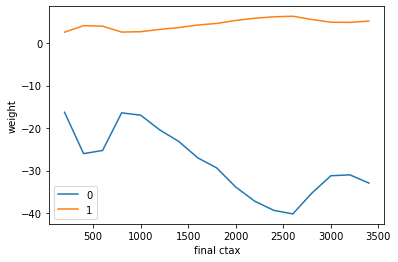

In [249]:
reload(emulate)

# only for this emulator we use combination of paths to train and test
# combi_paths = emulate.combi_df(cubic_paths, root_paths, cubic_reduction, root_reduction)

x = emulate.CtaxRedEmulator(lin_paths, cubic_paths)

x.train_ctax_path(10, 2)

# do it for all remaining test paths
cubic_test = []
root_test = []

for i in range(1, len(root_paths), 2):
        
    cubic_test.append(x.test_ctax_1by1(root_paths.loc[i]))
    root_test.append(x.test_ctax_1by1(cubic_paths.loc[i+1])) 

print(cubic_test)    
    
# x.test_ctax_paths() 


In [152]:
test = np.array([1,2,3,4,5,6])
test_reshape = test.reshape(-1,2)
print(test_reshape)

check = np.array([2,4,6])
check = check.reshape(-1,1)
print(check)

print(test_reshape[test_reshape[:,-1] == check[:,-1]])

[[1 2]
 [3 4]
 [5 6]]
[[2]
 [4]
 [6]]
[[1 2]
 [3 4]
 [5 6]]


RMSE:  10.716131321975832
R-squared:  0.6208078816965195


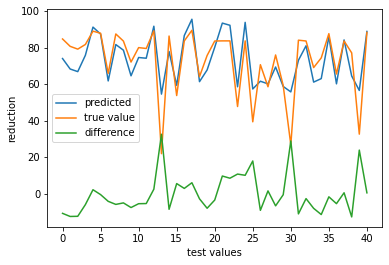

In [295]:
reload(emulate)

x.emulate_ctax_MLR()

# x.train_ctax_LR()

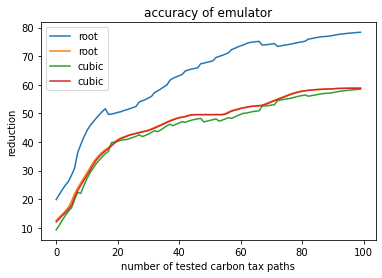

In [250]:
"""
Figures showing the emulated reduction vs real reduction

Also calculation of MSE

zelfde kleuren maar andere weergave
"""

reload(v1_plot)

v1_plot.emulator_v1_graphs(cubic_test, root_test)